In [103]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.callbacks import Callback
from google.colab import drive, files

In [44]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# Definisikan path dataset
train_data_dir = '/content/drive/MyDrive/capstone_project/fishify/datasets/Roboflow Dataset/train'
valid_data_dir = '/content/drive/MyDrive/capstone_project/fishify/datasets/Roboflow Dataset/valid'
# Tentukan parameter-model
batch_size = 32
image_size = (224, 224)
epochs = 25

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Persiapkan data train
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Persiapkan data validation
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 546 images belonging to 13 classes.
Found 77 images belonging to 13 classes.


In [90]:
class CustomEarlyStopping(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.85 and logs.get('accuracy') > 0.85:
            print("\nTraining is stopped as val_accuracy > 0.85, accuracy > 0.85")
            self.model.stop_training = True

In [98]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),# Adding dropout with a dropout rate (adjust as needed)
    layers.Dense(13, activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [99]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[CustomEarlyStopping()]
)

Epoch 1/25
17/17 [==============================] - 27s 1s/step - loss: 1.8641 - accuracy: 0.4008 - val_loss: 0.9607 - val_accuracy: 0.7188
Epoch 2/25
17/17 [==============================] - 22s 1s/step - loss: 0.6648 - accuracy: 0.8307 - val_loss: 0.4721 - val_accuracy: 0.9219
Epoch 3/25
17/17 [==============================] - 21s 1s/step - loss: 0.3770 - accuracy: 0.8988 - val_loss: 0.4740 - val_accuracy: 0.8438
Epoch 4/25
17/17 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.9241
Training is stopped as val_accuracy > 0.85, accuracy > 0.85
17/17 [==============================] - 22s 1s/step - loss: 0.2654 - accuracy: 0.9241 - val_loss: 0.4035 - val_accuracy: 0.8594


In [101]:
# Simpan model
model.save('/content/drive/MyDrive/capstone_project/model/model_v6_rozi_10Desember.h5')

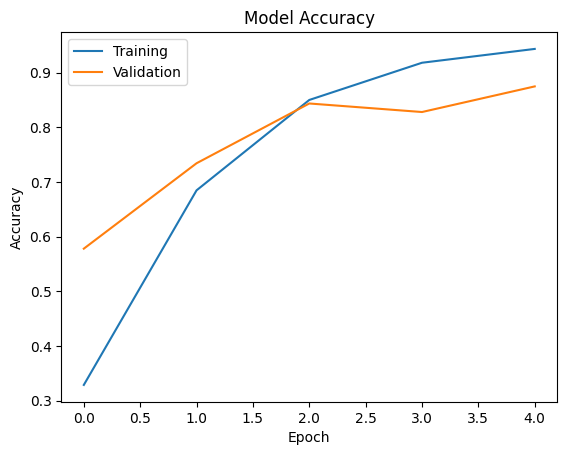

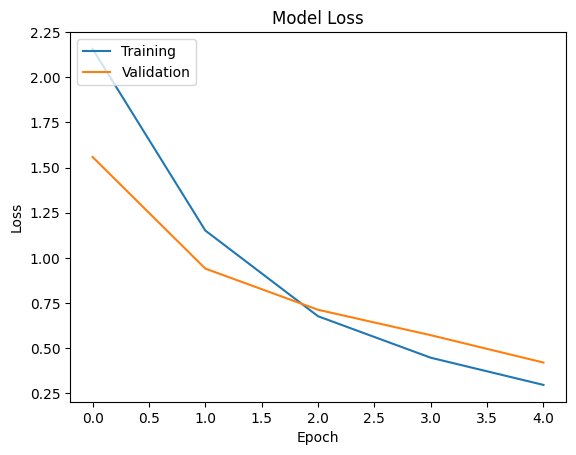

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Plot grafik loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Predict


In [31]:
from google.colab import files

In [ ]:
import os
import glob

# Define the path to the folder containing subfolders with images for prediction
prediction_folder = '/content/drive/MyDrive/capstone_project/fishify/datasets/fish/Validation'

# Get the list of subfolders (each subfolder represents a class)
class_folders = [f.path for f in os.scandir(prediction_folder) if f.is_dir()]

# Specify the number of files to process for each class
num_files_to_process = 10

# Iterate through each class folder
for class_folder in class_folders:
    print(f"\nClass: {os.path.basename(class_folder)}")

    # Get the list of image files in the current class folder
    image_files = glob.glob(os.path.join(class_folder, '*.jpg'))[:num_files_to_process]  # Adjust the file extension as needed

    # Iterate through each image file in the class folder
    for img_path in image_files:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array_expanded_dims = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(img_array_expanded_dims)

        # Predict the class probabilities
        probabilities = model.predict(preprocessed_img)[0]

        # Display the image
        plt.imshow(img)
        plt.show()

        # Display the predicted class and probability
        for (class_label, probability) in zip(class_labels, probabilities):
            print(f"{class_label}: {probability * 100:.2f}%")

# Note: Adjust the file extension in the glob statement based on the format of your image files (e.g., '*.jpg', '*.png', etc.)


# Convert TFLite

In [105]:
# Load your existing model
model_path = '/content/drive/MyDrive/capstone_project/model/model_v6_rozi_10Desember.h5'
model = tf.keras.models.load_model(model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to Google Drive
drive_path = '/content/drive/MyDrive/capstone_project/model'
tflite_model_path = 'Fishify_model.tflite'

with open(drive_path + tflite_model_path, 'wb') as f:
    f.write(tflite_model)
